[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AnyLoc/AnyLoc/blob/main/demo/anyloc_vlad_generate_colab.ipynb)

# AnyLoc VLAD DINOv2 Descriptors

Given a folder of images, this notebook generates global descriptors per image and stores the result in another folder. The global descriptors are created using VLAD over DINOv2 features from a particular layer and facet of transformer (default is from the paper).

We'll use images from [FAB-MAP: Probabilistic Localization and Mapping in the Space of Appearance](https://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/) (data from [here](https://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/data.html)) as an example. This will be downloaded if it doesn't exist.


## Setup


### Google Colab

- Run this section only if running this notebook on Google Colab.
- If you're running this section on your local machine, jump to `Downloading data` sub-section.

In [ ]:
# Ensure that utilities.py module is there
import os
import requests
if os.path.isfile('utilities.py'):
    print('Found utilities.py')
else:
    print("Could not find utilities.py, downloading it")
    url = "https://raw.githubusercontent.com/AnyLoc/AnyLoc/main/demo/utilities.py"
    file_data = requests.get(url, allow_redirects=True)
    with open('utilities.py', 'wb') as handler:
        handler.write(file_data.content)
    print("Done")

Could not find utilities.py, downloading it
Done


In [ ]:
print("Verifying NVIDIA GPU is available")
!nvidia-smi -L
print("Please see that the GPU has at least 16 GB VRAM free")
!nvidia-smi

Verifying NVIDIA GPU is available
GPU 0: Tesla T4 (UUID: GPU-d6ec4b0e-3b84-ef20-2b37-e2dc201595e0)
Please see that the GPU has at least 16 GB VRAM free
Sun Dec  3 08:48:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+---------------

Ensure that packages are installed

In [ ]:
# Install other things
print("Trying to access utility libraries")
try:
    import einops
    import fast_pytorch_kmeans
    import faiss
    import distinctipy
    import onedrivedownloader
    print("Can access utility libraries")
except ImportError:
    print("Installing utility libraries")
    !pip install fast_pytorch_kmeans
    !pip install faiss-gpu
    !pip install einops
    !pip install distinctipy
    !pip install onedrivedownloader

Trying to access utility libraries
Installing utility libraries
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00


#### Downloading Data

Downloading

- `cache`: Vocabulary (cluster centers) and test images
- `data`: Images that we'll use for testing


In [ ]:
# Download cache data from OneDrive
from onedrivedownloader import download
from utilities import od_down_links#, get_top_k_recall
# Link
ln = od_down_links["cache"]
# Download and unzip
if os.path.isdir("./cache"):
    print("Cache folder already exists!")
else:
    print("Downloading the cache folder")
    download(ln, filename="cache.zip", unzip=True, unzip_path="./")
    print("Cache folder downloaded")

100%|██████████| 231M/231M [00:08<00:00, 26.9MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 96/96 [00:03<00:00, 28.64it/s] 

Cache folder downloaded


In [ ]:
# Download the data (images)
use_odrive = True   # If True, use personal OneDrive (not official links)
if use_odrive:
    print("Downloading images from OneDrive ...")
    imgs_link = od_down_links["test_imgs_od"]
    download(imgs_link, "./data/CityCenter/Images.zip", unzip=True, unzip_path="./data/CityCenter")
    print("Download and extraction of images from OneDrive completed")
else:
    print("Downloading from original source")
    imgs_link = od_down_links["test_imgs"]
    if os.path.isdir("./data/CityCenter"):
        print("Directory already exists")
    else:
        os.makedirs("./data/CityCenter")
        print("Directory created")
    !wget $imgs_link -O ./data/CityCenter/Images.zip
    print("Extraction completed")

100%|██████████| 583M/583M [00:21<00:00, 26.8MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 2475/2475 [00:07<00:00, 315.50it/s]

Download and extraction of images from OneDrive completed


In [ ]:
# Ensurer that everything went smoothly
# einimgs_dir
import glob
_ex = lambda x: os.path.realpath(os.path.expanduser(x))
cache_dir: str = _ex("./cache")
imgs_dir = _ex("./data/CityCenter/Images/")
assert os.path.isdir(cache_dir), "Cache directory not found"
assert os.path.isdir(imgs_dir), "Invalid unzipping"
num_imgs = len(glob.glob(f"{imgs_dir}/*.jpg"))
print(f"Found {num_imgs} images in {imgs_dir}")

Found 2474 images in /content/data/CityCenter/Images


### Import Everything

In [ ]:
# Import everything
import numpy as np
import cv2 as cv
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms as tvf
from torchvision.transforms import functional as T
from PIL import Image
import matplotlib.pyplot as plt
import distinctipy as dipy
from tqdm.auto import tqdm
from typing import Literal, List, Tuple
import os
import natsort
import shutil
from copy import deepcopy
# DINOv2 imports
from utilities import DinoV2ExtractFeatures
from utilities import VLAD

## Building Global Descriptors

Save global descriptors as numpy arrays to a directory (mirroring the directory structure of the dataset).


In [ ]:
# # Program parameters
# save_dir = _ex("./data/CityCenter/GD_Images/")
# device = torch.device("cuda")
# # Dino_v2 properties (parameters)
# desc_layer: int = 31
# desc_facet: Literal["query", "key", "value", "token"] = "value"
# num_c: int = 32
# # Domain for use case (deployment environment)
# domain: Literal["aerial", "indoor", "urban"] = "urban"
# # Maximum image dimension
# max_img_size: int = 1024


# Program parameters
save_dir = "./gardens/descriptors/"
cache_dir = "./gardens/cache/"
# img_dir = "./gardens/"
device = torch.device("cuda")
# Dino_v2 properties (parameters)
desc_layer: int = 31
desc_facet: Literal["query", "key", "value", "token"] = "value"
num_c: int = 32
# Domain for use case (deployment environment)
domain: Literal["aerial", "indoor", "urban"] = "urban"
# Maximum image dimension
max_img_size: int = 1024

In [ ]:
# Ensure inputs are fine
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    print(f"Creating directory: {save_dir}")
else:
    print("Save directory already exists, overwriting possible!")

Creating directory: ./gardens/descriptors/


### DINOv2 Extractor

DINOv2 extractor and the base transformation (for each image)

In [ ]:
# DINO extractor
if "extractor" in globals():
    print(f"Extractor already defined, skipping")
else:
    extractor = DinoV2ExtractFeatures("dinov2_vitg14", desc_layer,
        desc_facet, device=device)
# Base image transformations
base_tf = tvf.Compose([
    tvf.ToTensor(),
    tvf.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
])

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitg14_pretrain.pth
100%|██████████| 4.23G/4.23G [00:25<00:00, 177MB/s]


### VLAD object

For forming global descriptors. Also loads the cluster centers (vocabulary) for VLAD.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/VNAV/


/content/drive/.shortcut-targets-by-id/1Xg2hxidUwcEigNrOyCh3l0l05EG9Xoxe/VNAV


In [ ]:
# Ensure that data is present
# ext_specifier = f"dinov2_vitg14/l{desc_layer}_{desc_facet}_c{num_c}"
# c_centers_file = os.path.join("/content/cache", "vocabulary", ext_specifier,
                            # domain, "c_centers.pt")

c_centers_file = os.path.join(cache_dir, "c_centers.pt")
print(c_centers_file)
assert os.path.isfile(c_centers_file), "Cluster centers not cached!"
c_centers = torch.load(c_centers_file)
assert c_centers.shape[0] == num_c, "Wrong number of clusters!"

print("Caching cluster centers on cpu")
torch.save(c_centers.cpu(),
        f"{cache_dir}/c_centers.pt")

./gardens/cache/c_centers.pt
Caching cluster centers on cpu


In [ ]:
# VLAD object
vlad = VLAD(num_c, desc_dim=None,
        cache_dir=os.path.dirname(c_centers_file))
# Fit (load) the cluster centers (this'll also load the desc_dim)
vlad.fit(None)

Using cached cluster centers
Desc dim set to 1536


In [ ]:
vlad.c_centers = vlad.c_centers.cpu()



In [ ]:
vlad.c_centers

tensor([[-0.0235,  0.0217, -0.0144,  ...,  0.0061,  0.0132,  0.0026],
        [-0.0042,  0.0021,  0.0155,  ..., -0.0073,  0.0079, -0.0086],
        [-0.0025, -0.0230, -0.0132,  ..., -0.0085,  0.0019, -0.0249],
        ...,
        [-0.0141, -0.0276,  0.0176,  ..., -0.0025, -0.0005, -0.0049],
        [-0.0061, -0.0047, -0.0035,  ..., -0.0010, -0.0039, -0.0289],
        [-0.0144,  0.0068,  0.0194,  ...,  0.0036,  0.0163, -0.0009]])

## Gardens setup

In [ ]:
# ext_specifier = f"dinov2_vitg14/l{desc_layer}_{desc_facet}_c{num_c}"
# c_centers_file = os.path.join("/content/cache", "vocabulary", ext_specifier,
#                             domain, "c_centers.pt")

# print(c_centers_file)
# # assert os.path.isfile(c_centers_file), "Cluster centers not cached!"
# c_centers = torch.load(c_centers_file)
# print(c_centers.shape)

/content/cache/vocabulary/dinov2_vitg14/l31_value_c32/urban/c_centers.pt
torch.Size([32, 1536])


In [ ]:

c_centers_file = os.path.join("/content/drive/MyDrive/VNAV/gardens/cache/c_centers.pt")
print(c_centers_file)
c_centers = torch.load(c_centers_file)
print(c_centers.shape)

/content/drive/MyDrive/VNAV/gardens/cache/c_centers.pt
torch.Size([32, 1536])


In [ ]:
# Gardens point dataset
"""
    From: https://zenodo.org/record/4590133#.ZAdKktJBxH5
"""

import pandas as pd
import os
import numpy as np
import cv2
import torch
import torch.utils.data
from typing import List, Union
from natsort import natsorted
# from configs import prog_args
# from scipy.spatial.transform import Rotation
# from scipy.spatial.distance import euclidean

from torch.utils.data import DataLoader

import os
import torch
import faiss
import numpy as np
from PIL import Image
import torchvision.transforms as T
from sklearn.neighbors import NearestNeighbors

# from utilities import CustomDataset

def path_to_pil_img(path):
    return Image.open(path).convert("RGB")

# base_transform = T.Compose([
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# mixVPR_transform = T.Compose([
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406],
#                             std=[0.229, 0.224, 0.225]),
#     T.Resize((320,320))
# ])

class Gardens():
    """
    Returns dataset class with images from database and queries for the gardens dataset.
    """
    def __init__(self,datasets_folder='./gardens',dataset_name="gardens",split="train",use_ang_positives=False,dist_thresh = 10,ang_thresh=20,use_mixVPR=False,use_SAM=False):
        # super().__init__()

        self.dataset_name = dataset_name
        self.datasets_folder = datasets_folder
        self.split = split
        self.use_mixVPR = use_mixVPR
        self.use_SAM = use_SAM
        self.db_paths = natsorted(os.listdir(os.path.join(self.datasets_folder,self.dataset_name,"day_right")))
        self.q_paths = natsorted(os.listdir(os.path.join(self.datasets_folder,self.dataset_name,"day_left")))

        self.db_abs_paths = []
        self.q_abs_paths = []

        # this sets day_right as database, night_right as query set
        # I also want to evaluate using day_left as query set. idk why they use day_left to set q_paths and its ignored later
        for p in self.db_paths:
            self.db_abs_paths.append(os.path.join(self.datasets_folder,self.dataset_name,"day_right",p))

        for q in self.q_paths:
            self.q_abs_paths.append(os.path.join(self.datasets_folder,self.dataset_name,"night_right",q))


        self.db_num = len(self.db_abs_paths)
        self.q_num = len(self.q_abs_paths)

        self.database_num = self.db_num
        self.queries_num = self.q_num

        self.gt_positives = np.load(os.path.join(self.datasets_folder,self.dataset_name,"gardens_gt.npy"),allow_pickle=True) #returns dictionary of gardens dataset

        self.images_paths = list(self.db_abs_paths) + list(self.q_abs_paths)

        self.soft_positives_per_query = []

        for i in range(len(self.gt_positives)):
            self.soft_positives_per_query.append(self.gt_positives[i][1]) #corresponds to index wise soft positives

    def __getitem__(self, index):
        img = Image.open(self.images_paths[index])

        # if self.use_mixVPR:
        #     img = mixVPR_transform(img)
        # elif self.use_SAM:
        #     img = cv2.imread(self.images_paths[index])
        #     img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        # else:
        #     img = base_transform(img)

        return img, index

In [ ]:
gardens_obj = Gardens(datasets_folder='./',
             dataset_name="gardens",
             split="train",
             use_ang_positives=False,
             dist_thresh = 10,
             ang_thresh=20,
             use_mixVPR=False,
             use_SAM=False
            )

### Global Descriptor Generation

Main generation stage. Creating global descriptors only for the first 20 images here.

In [ ]:

c_centers_file = os.path.join("/content/drive/MyDrive/VNAV/gardens/cache/c_centers.pt")
print(c_centers_file)
c_centers = torch.load(c_centers_file)
print(c_centers.shape)
c_centers

/content/drive/MyDrive/VNAV/gardens/cache/c_centers.pt
torch.Size([32, 1536])


tensor([[-0.0235,  0.0217, -0.0144,  ...,  0.0061,  0.0132,  0.0026],
        [-0.0042,  0.0021,  0.0155,  ..., -0.0073,  0.0079, -0.0086],
        [-0.0025, -0.0230, -0.0132,  ..., -0.0085,  0.0019, -0.0249],
        ...,
        [-0.0141, -0.0276,  0.0176,  ..., -0.0025, -0.0005, -0.0049],
        [-0.0061, -0.0047, -0.0035,  ..., -0.0010, -0.0039, -0.0289],
        [-0.0144,  0.0068,  0.0194,  ...,  0.0036,  0.0163, -0.0009]])

In [ ]:
ext_specifier = f"dinov2_vitg14/l{desc_layer}_{desc_facet}_c{num_c}"
c_centers_file = os.path.join("/content/cache", "vocabulary", ext_specifier,
                            domain, "c_centers.pt")

print(c_centers_file)
# assert os.path.isfile(c_centers_file), "Cluster centers not cached!"
c_centers = torch.load(c_centers_file)
print(c_centers.shape)
c_centers

/content/cache/vocabulary/dinov2_vitg14/l31_value_c32/urban/c_centers.pt
torch.Size([32, 1536])


tensor([[ 0.0162,  0.0226, -0.0163,  ..., -0.0049,  0.0022,  0.0035],
        [ 0.0046, -0.0036,  0.0139,  ...,  0.0072, -0.0038, -0.0018],
        [ 0.0035,  0.0087,  0.0090,  ...,  0.0098,  0.0291, -0.0029],
        ...,
        [ 0.0190,  0.0023,  0.0073,  ...,  0.0106, -0.0031,  0.0123],
        [-0.0084,  0.0044, -0.0058,  ..., -0.0214,  0.0075,  0.0107],
        [ 0.0035,  0.0091,  0.0078,  ..., -0.0230, -0.0074, -0.0014]])

In [35]:
img_fnames = glob.glob(f"/content/data/CityCenter/Images/*.jpg")
print(img_fnames[0])
print(f"{save_dir}/{os.path.basename(img_fnames[0])}")

/content/data/CityCenter/Images/2025.jpg
/content/data/CityCenter/GD_Images/2025.jpg


In [ ]:
# img_fnames = glob.glob(f"/content/data/CityCenter/Images/*.jpg")
img_fnames = gardens_obj.db_abs_paths
img_fnames = natsort.natsorted(img_fnames)
for img_fname in tqdm(img_fnames[:2]):

    # DINO features
    with torch.no_grad():
        pil_img = Image.open(img_fname).convert('RGB')
        img_pt = base_tf(pil_img).to(device)
        if max(img_pt.shape[-2:]) > max_img_size:
            c, h, w = img_pt.shape
            # Maintain aspect ratio
            if h == max(img_pt.shape[-2:]):
                w = int(w * max_img_size / h)
                h = max_img_size
            else:
                h = int(h * max_img_size / w)
                w = max_img_size
            print(f"To {(h, w) =}")
            img_pt = T.resize(img_pt, (h, w),
                    interpolation=T.InterpolationMode.BICUBIC)
            print(f"Resized {img_fname} to {img_pt.shape = }")
        # Make image patchable (14, 14 patches)
        c, h, w = img_pt.shape
        h_new, w_new = (h // 14) * 14, (w // 14) * 14
        img_pt = tvf.CenterCrop((h_new, w_new))(img_pt)[None, ...]
        # Extract descriptor
        ret = extractor(img_pt) # [1, num_patches, desc_dim]
    # VLAD global descriptor
    gd = vlad.generate(ret.cpu().squeeze()) # VLAD: shape [agg_dim]
    gd_np = gd.numpy()[np.newaxis, ...] # shape: [1, agg_dim]
    np.save(f"{save_dir}/{os.path.basename(img_fname)}.npy", gd_np)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
print(gd_np.shape)

(1, 49152)


In [ ]:
type(gd)

torch.Tensor

Done

In [ ]:
data = []
for img_fname in tqdm(img_fnames[:20]):
    data.append(torch.from_numpy(np.load(f"{save_dir}/{os.path.basename(img_fname)}.npy")))


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
minidb = torch.cat(data, dim=0)
qu = minidb[0]
gt_pos = np.array([0])

In [ ]:
print(minidb.shape)
print(qu.shape)

torch.Size([20, 49152])
torch.Size([49152])


In [ ]:
data

[tensor([[ 0.0137, -0.0018,  0.0063,  ...,  0.0093, -0.0065, -0.0041]]),
 tensor([[ 0.0033,  0.0079, -0.0008,  ...,  0.0026,  0.0003, -0.0071]]),
 tensor([[ 0.0126,  0.0017,  0.0028,  ...,  0.0070,  0.0009, -0.0067]]),
 tensor([[ 0.0161,  0.0014,  0.0058,  ...,  0.0044, -0.0041,  0.0002]]),
 tensor([[ 0.0022, -0.0032,  0.0064,  ...,  0.0085, -0.0010, -0.0037]]),
 tensor([[-0.0013, -0.0072,  0.0028,  ...,  0.0021, -0.0067,  0.0015]]),
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0049, -0.0002, -0.0070]]),
 tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0006, -0.0043,  0.0016]]),
 tensor([[ 0.0097, -0.0104,  0.0045,  ...,  0.0031,  0.0011, -0.0035]]),
 tensor([[-0.0020, -0.0105, -0.0014,  ...,  0.0023, -0.0027, -0.0027]]),
 tensor([[ 0.0108, -0.0063,  0.0022,  ...,  0.0018,  0.0031, -0.0058]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[ 0.0112,  0.0016,  0.0017,  ...,  0.0031, -0.0014, -0.0030]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[ 0.0017, -0.0079,  0.0012,  

In [ ]:
torch.min(data[0][0])

# np.min(data[0][0]), np.max(data[0][0])



tensor(-0.0252)

recall eval tests

In [ ]:
# from utils
# %% -------------------- Recall Calculations --------------------
import faiss
import faiss.contrib.torch_utils
import typing

def get_top_k_recall(top_k: List[int], db: torch.Tensor,
        qu: torch.Tensor, gt_pos: np.ndarray, method: str="cosine",
        norm_descs: bool=True, use_gpu: bool=False,
        use_percentage: bool=True, sub_sample_db: int=1,
        sub_sample_qu: int=1) -> Tuple[np.ndarray, np.ndarray, dict]:
    """
        Given a database and query (or queries), get the top 'k'
        retrievals (closest in database for each query) as indices (in
        database), distances, and recalls.

        Parameters:
        - top_k:    List of 'k' values for recall calculation. Eg:
                    `list(range(1, 11))`.
        - db:       Database descriptors of shape [n_db, d_dim].
        - qu:       Query descriptors of shape [n_qu, d_dim]. If only
                    one query (n_qu = 1), then shape [d_dim].
        - gt_pos:   Ground truth for retrievals. Should be object type
                    with gt_pos[i] having true database items
                    (indices) for the query 'i' (in `qu`).
        - method:   Method for faiss search. In {'cosine', 'l2'}.
        - norm_descs:   If True, the descriptors are normalized in
                        function.
        - use_gpu:  True if indexing (search) should be on GPU.
        - use_percentage:   If True, the recalls are returned as a
                            percentage (of queries resolved).
        - sub_sample_db:    Sub-sample database samples from the
                            ground truth 'gt_pos'
        - sub_sample_qu:    Sub-sample query samples from the ground
                            truth 'gt_pos'

        Returns:
        - distances:    The distances of queries to retrievals. The
                        shape is [n_qu, max(top_k)]. It is the
                        distance (as specified in `method`) with the
                        database item retrieved (index in `indices`).
                        Sorted by distance.
        - indices:      Indices of the database items retrieved. The
                        shape is [n_qu, max(top_k)]. Sorted by
                        distance.
        - recalls:      A dictionary with keys as top_k integers, and
                        values are the recall (number or percentage)
                        of correct retrievals for queries.
    """
    if len(qu.shape) == 1:
        qu = qu.unsqueeze(0)
    if norm_descs:
        db = F.normalize(db)
        qu = F.normalize(qu)
    D = db.shape[1]
    if method == "cosine":
        index = faiss.IndexFlatIP(D)
    elif method == "l2":
        index = faiss.IndexFlatL2(D)
    else:
        raise NotImplementedError(f"Method: {method}")
    if use_gpu:
        res = faiss.StandardGpuResources()
        index = faiss.index_cpu_to_gpu(res, 0 , index)
    # Get the max(top-k) retrieval, then traverse list
    index.add(db)
    distances, indices = index.search(qu, max(top_k))
    recalls = dict(zip(top_k, [0]*len(top_k)))
    # print(qu.shape,indices.shape)
    for i_qu, qu_retr in enumerate(indices):
        for i_rec in top_k:
            # Correct database images (for the retrieval)
            """
                i_qu * sub_sample_qu
                    Sub-sampled queries (step)
                qu_retr[:i_rec] * sub_sample_db
                    Sub-sampled database (step in retrievals)
            """
            correct_retr = gt_pos[i_qu * sub_sample_qu]
            if np.any(np.isin(qu_retr[:i_rec] * sub_sample_db,
                        correct_retr)):
                recalls[i_rec] += 1
    if use_percentage:
        for k in recalls:
            recalls[k] /= len(indices)
    return distances, indices, recalls


In [ ]:
# get_top_k_recall(top_k: List[int], db: torch.Tensor,
#         qu: torch.Tensor, gt_pos: np.ndarray, method: str="cosine",
#         norm_descs: bool=True, use_gpu: bool=False,
#         use_percentage: bool=True, sub_sample_db: int=1,
#         sub_sample_qu: int=1)

        # Returns:
        # - distances:    The distances of queries to retrievals. The
        #                 shape is [n_qu, max(top_k)]. It is the
        #                 distance (as specified in `method`) with the
        #                 database item retrieved (index in `indices`).
        #                 Sorted by distance.
        # - indices:      Indices of the database items retrieved. The
        #                 shape is [n_qu, max(top_k)]. Sorted by
        #                 distance.
        # - recalls:      A dictionary with keys as top_k integers, and
        #                 values are the recall (number or percentage)
        #                 of correct retrievals for queries.


get_top_k_recall(list(range(1,3)), minidb, qu, gt_pos)

NameError: ignored

In [ ]:
!mkdir gardens

import shutil
shutil.unpack_archive("drive/MyDrive/File_Name.zip", "Extracting_folder/")



Archive:  gardens.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of gardens.zip or
        gardens.zip.zip, and cannot find gardens.zip.ZIP, period.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


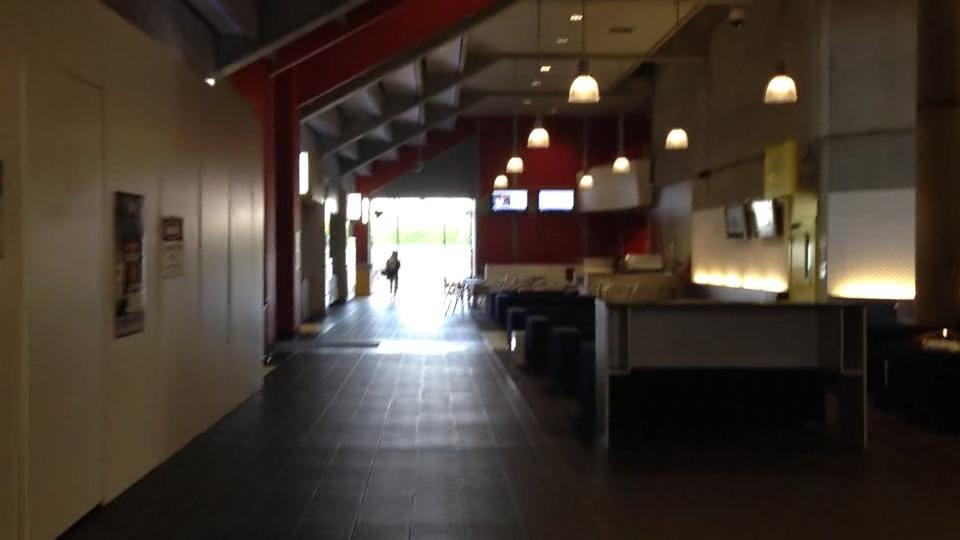

In [ ]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
display(ds.__getitem__(14)[0])

In [ ]:
import numpy as np
gt = np.load(("./gardens/gardens_gt.npy"),allow_pickle=True) #returns dictionary of gardens dataset


In [ ]:
ds.soft_positives_per_query

[[0, 1, 2],
 [0, 1, 2, 3],
 [0, 1, 2, 3, 4],
 [1, 2, 3, 4, 5],
 [2, 3, 4, 5, 6],
 [3, 4, 5, 6, 7],
 [4, 5, 6, 7, 8],
 [5, 6, 7, 8, 9],
 [6, 7, 8, 9, 10],
 [7, 8, 9, 10, 11],
 [8, 9, 10, 11, 12],
 [9, 10, 11, 12, 13],
 [10, 11, 12, 13, 14],
 [11, 12, 13, 14, 15],
 [12, 13, 14, 15, 16],
 [13, 14, 15, 16, 17],
 [14, 15, 16, 17, 18],
 [15, 16, 17, 18, 19],
 [16, 17, 18, 19, 20],
 [17, 18, 19, 20, 21],
 [18, 19, 20, 21, 22],
 [19, 20, 21, 22, 23],
 [20, 21, 22, 23, 24],
 [21, 22, 23, 24, 25],
 [22, 23, 24, 25, 26],
 [23, 24, 25, 26, 27],
 [24, 25, 26, 27, 28],
 [25, 26, 27, 28, 29],
 [26, 27, 28, 29, 30],
 [27, 28, 29, 30, 31],
 [28, 29, 30, 31, 32],
 [29, 30, 31, 32, 33],
 [30, 31, 32, 33, 34],
 [31, 32, 33, 34, 35],
 [32, 33, 34, 35, 36],
 [33, 34, 35, 36, 37],
 [34, 35, 36, 37, 38],
 [35, 36, 37, 38, 39],
 [36, 37, 38, 39, 40],
 [37, 38, 39, 40, 41],
 [38, 39, 40, 41, 42],
 [39, 40, 41, 42, 43],
 [40, 41, 42, 43, 44],
 [41, 42, 43, 44, 45],
 [42, 43, 44, 45, 46],
 [43, 44, 45, 46, 47],
 

In [ ]:
%pwd

'/content/drive/MyDrive/VNAV'

In [ ]:
img_fnames = glob.glob("./gardens/day_left/*.jpg")
print(img_fnames)

['./gardens/day_left/Image169.jpg', './gardens/day_left/Image150.jpg', './gardens/day_left/Image115.jpg', './gardens/day_left/Image101.jpg', './gardens/day_left/Image145.jpg', './gardens/day_left/Image113.jpg', './gardens/day_left/Image029.jpg', './gardens/day_left/Image049.jpg', './gardens/day_left/Image072.jpg', './gardens/day_left/Image014.jpg', './gardens/day_left/Image117.jpg', './gardens/day_left/Image103.jpg', './gardens/day_left/Image005.jpg', './gardens/day_left/Image036.jpg', './gardens/day_left/Image177.jpg', './gardens/day_left/Image037.jpg', './gardens/day_left/Image062.jpg', './gardens/day_left/Image137.jpg', './gardens/day_left/Image040.jpg', './gardens/day_left/Image044.jpg', './gardens/day_left/Image054.jpg', './gardens/day_left/Image186.jpg', './gardens/day_left/Image026.jpg', './gardens/day_left/Image135.jpg', './gardens/day_left/Image033.jpg', './gardens/day_left/Image198.jpg', './gardens/day_left/Image042.jpg', './gardens/day_left/Image158.jpg', './gardens/day_left

In [ ]:
# img_fnames = glob.glob(f"{imgs_dir}/*.jpg")
img_fnames = natsort.natsorted(img_fnames)
for img_fname in tqdm(img_fnames[:5]):
    # DINO features
    with torch.no_grad():
        pil_img = Image.open(img_fname).convert('RGB')
        img_pt = base_tf(pil_img).to(device)
        if max(img_pt.shape[-2:]) > max_img_size:
            c, h, w = img_pt.shape
            # Maintain aspect ratio
            if h == max(img_pt.shape[-2:]):
                w = int(w * max_img_size / h)
                h = max_img_size
            else:
                h = int(h * max_img_size / w)
                w = max_img_size
            print(f"To {(h, w) =}")
            img_pt = T.resize(img_pt, (h, w),
                    interpolation=T.InterpolationMode.BICUBIC)
            print(f"Resized {img_fname} to {img_pt.shape = }")
        # Make image patchable (14, 14 patches)
        c, h, w = img_pt.shape
        h_new, w_new = (h // 14) * 14, (w // 14) * 14
        img_pt = tvf.CenterCrop((h_new, w_new))(img_pt)[None, ...]
        # Extract descriptor
        ret = extractor(img_pt) # [1, num_patches, desc_dim]
    # VLAD global descriptor
    gd = vlad.generate(ret.cpu().squeeze()) # VLAD: shape [agg_dim]
    gd_np = gd.numpy()[np.newaxis, ...] # shape: [1, agg_dim]
    np.save(f"{save_dir}/{os.path.basename(img_fname)}.npy", gd_np)

  0%|          | 0/5 [00:00<?, ?it/s]

In [3]:

import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import tqdm
